# Analysis


In [297]:
# %load first_cell.py
%reload_ext autoreload
%autoreload 2
from pathlib import Path
home = str(Path.home())

import sys
sys.path = sys.path + [f'{home}/.conda/envs/norm_env/lib/python37.zip', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/lib-dynload', 
                       f'{home}/.conda/envs/norm_env/lib/python3.7/site-packages']
sys.prefix = '/home/soniame/.conda/envs/norm_env'

from paths import RAW_PATH, TREAT_PATH, OUTPUT_PATH, FIGURES_PATH

from copy import deepcopy
import numpy as np
import pandas as pd
pd.options.display.max_columns = 999
import yaml
import matplotlib.pyplot as plt 
from datetime import datetime

import warnings
warnings.filterwarnings('ignore')

# Plotting
import plotly
import plotly.graph_objs as go
import cufflinks as cf
plotly.offline.init_notebook_mode(connected=True)

def iplottitle(title, width=40):
    return '<br>'.join(textwrap.wrap(title, width))
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="white", rc={"axes.facecolor": (0, 0, 0, 0)})

import plotnine as p9
from mizani.breaks import date_breaks
from mizani.formatters import date_format
p9.theme_set(p9.theme_linedraw()) # default theme

# Setting cufflinks
import textwrap
import cufflinks as cf
cf.go_offline()
cf.set_config_file(offline=False, world_readable=True)
import yaml
from jinja2 import Template
cf.themes.THEMES['custom'] = yaml.load(open('cufflinks_template.yaml', 'r'))

# Manipulation 
from siuba import *

# Outliers
from adtk.data import validate_series
from adtk.transformer import DoubleRollingAggregate
from adtk.visualization import plot
from adtk.pipe import Pipeline
from adtk.detector import QuantileAD
from adtk.transformer import ClassicSeasonalDecomposition

## Load data

### dahsboard data

In [298]:
from src import utils

conn = utils.connect_athena(path='../configs/athena.yaml')
df = pd.read_sql_query("""
select 
    *,
    date_parse(concat(cast(year as varchar), ' ', cast(month as varchar), ' ', cast(day as varchar)), '%Y %m %e') date
from spd_sdv_waze_corona.prod_daily_daily_index
where region_slug = 'country_mexico'
""", conn)

In [299]:
#df.head()

### mobility

In [117]:
df_union=pd.read_csv("/home/soniame/shared/spd-sdv-omitnik-waze/corona/mobility/region_city_union.csv") 
df_mean = (df_union
 >> filter(_.date >= '2020-03-23', _.date <= '2020-03-29')
 >> group_by('region_slug', 'measure')
 >> summarize(mean_val = _.value.mean())
 >> ungroup()
)
df_mean.head()
df_scale = (df_union.merge(df_mean.reset_index(), on=['region_slug', 'measure'], how='left')
 >> mutate(value_rescaled = -100*_.value/_.mean_val)
 >> select('region_slug', 'country_name', 'date', 'measure', 'value_rescaled')
 >> spread('measure', 'value_rescaled')
)
df_scale['date'] = df_scale['date'].apply(lambda x : datetime.strptime(x, '%Y-%m-%d'))
#df_scale.dtypes

## Day of week data

In [118]:
df_dow = (df
 >> select( 'region_slug', 'date',  'dow', 'observed', 'tcp') 
 >> mutate( aux_var = (_.dow == 1))
 >> arrange(_.region_slug, _.date)
 >> group_by('region_slug')
 >> mutate( week = _.aux_var.cumsum())
 >> ungroup()
 >> group_by('region_slug', 'week')
 >> mutate( min_date = _.date.min())
 >> ungroup()
 >> select( 'region_slug', 'dow', 'date', 'min_date', 'week', 'observed', 'tcp')
 >> arrange('region_slug', 'dow', 'date')
 >> group_by('region_slug', 'dow')
 >> mutate(tcp_ma = _.tcp.rolling(3).mean(),
           obs_ma = _.observed.rolling(3).mean())
 >> ungroup()          
).dropna()
df_dow['log_observed'] = np.log(df_dow['observed'])

In [119]:
#df_dow.head()

In [120]:
#(p9.ggplot(data=(df_dow
#                 >> select('region_slug', 'dow', 'date', 'week', 
#                           'tcp_ma', 'obs_ma', 'observed')
#                 >> gather('measure', 'value', _["tcp_ma", "obs_ma", "observed"])),
#           mapping=p9.aes(x='week', y='value', 
#                          color = 'dow', group = 'dow')) 
#    + p9.geom_line(size=1) 
#    + p9.facet_wrap(['region_slug', 'measure'], ncol = 1, scales='free') 
#    + p9.theme(figure_size = (6, 8),
#                axis_text_x=p9.element_text(angle=0)) )

In [121]:
tab = (df_dow
 >> group_by('region_slug', 'dow')
 >> summarize(n_obs = _.min_date.count())
 >> ungroup()
)
spread(tab, 'dow', 'n_obs')

,region_slug,1,2,3,4,5,6,7
0,country_mexico,51,50,50,50,50,50,50


[<AxesSubplot:>]

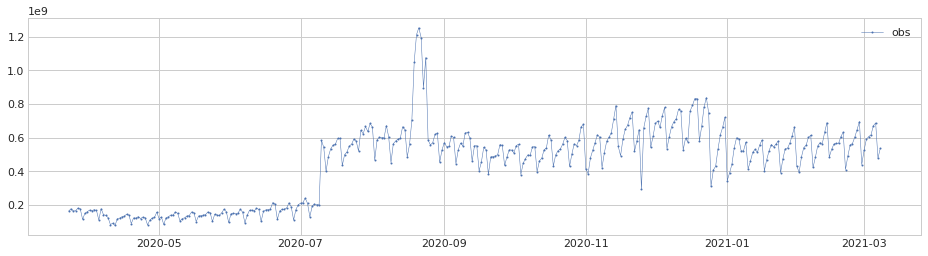

In [124]:
# series to validate
y_df = df_dow \
    .siu_arrange('date') \
    .siu_rename(obs = 'observed') \
    .siu_select('date', 'obs') \
    .set_index('date')
s_c = validate_series(y_df)
plot(s)

## Outliers detection

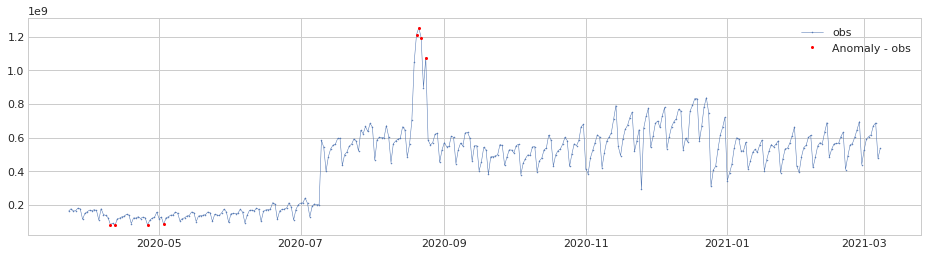

In [125]:
quantile_ad = QuantileAD(high=0.99, low=0.01)
steps = [
    ("quantile_ad", QuantileAD(high=0.99, low=0.01))
]
pipeline = Pipeline(steps)
anomalies_pipe = pipeline.fit_detect(s_c)
plot(s_c, anomaly=anomalies_pipe, ts_markersize=1, anomaly_markersize=2, anomaly_tag="marker", anomaly_color='red');

In [126]:
(anomalies_pipe \
    .rename(columns={'obs':'outlier'}) \
    .reset_index() \
    .merge(df_dow, how='inner')
 >> group_by('dow', 'region_slug')
 >> summarize(n_obs = _.date.count(),
              n_out = _.outlier.sum())
 >> ungroup()
 >> mutate(pct_out = 100*_.n_out/_.n_obs)
)

,dow,region_slug,n_obs,n_out,pct_out
0,1,country_mexico,51,1,1.960784
1,2,country_mexico,50,0,0.000000
2,3,country_mexico,50,0,0.000000
3,4,country_mexico,50,1,2.000000
4,5,country_mexico,50,2,4.000000
5,6,country_mexico,50,1,2.000000
6,7,country_mexico,50,3,6.000000


## Smoothing for day of the week

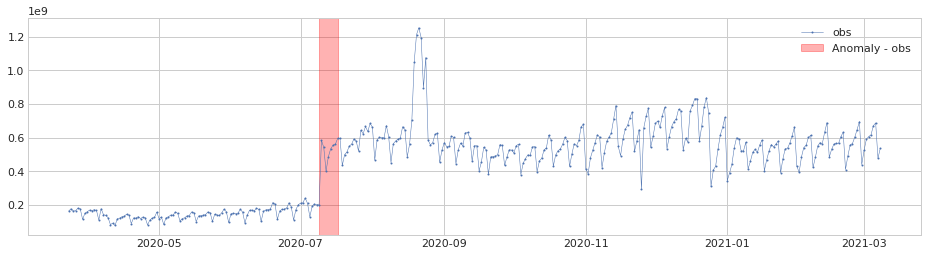

In [127]:
from adtk.detector import LevelShiftAD
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=14)
anomalies = level_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

In [130]:
anomalies.siu_filter(_.obs ==1)

,obs
date,
2020-07-09,1.0
2020-07-10,1.0
2020-07-11,1.0
2020-07-12,1.0
2020-07-13,1.0
2020-07-14,1.0
2020-07-15,1.0
2020-07-16,1.0


In [131]:
((df_dow[(df_dow['date'] > '2020-06-25') & (df_dow['date'] <= '2020-07-09')].observed.mean())-( df_dow[(df_dow['date'] > '2020-07-09') & (df_dow['date'] <= '2020-07-23')].observed.mean()))

-337479847.71428573

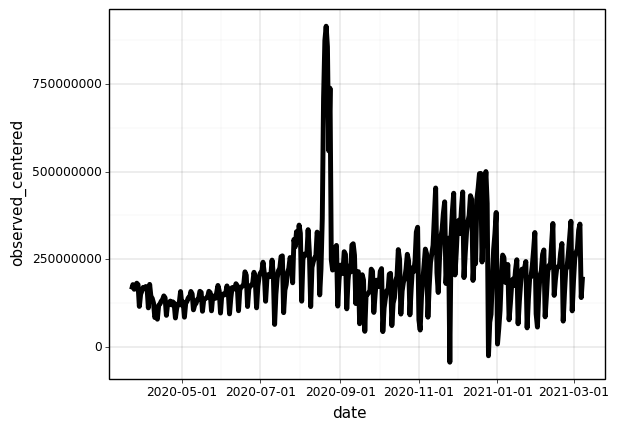

<ggplot: (8764288759789)>

In [144]:

df_dow['observed_centered'] = df_dow['observed']
df_dow['observed_centered'][(df_dow['date'] > '2020-07-09')] = df_dow['observed'][(df_dow['date'] > '2020-07-09')] -337479847.71428573
(p9.ggplot(data=df_dow,
           mapping=p9.aes(x='date', y='observed_centered')) 
    + p9.geom_line(size = 2) 
)

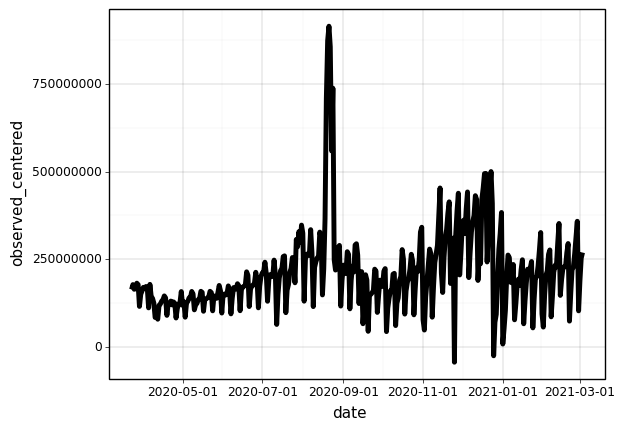

<ggplot: (8757122776069)>

In [813]:
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=14)
anomalies = level_shift_ad.fit_detect(s)
plot(s, anomaly=anomalies, anomaly_color='red');

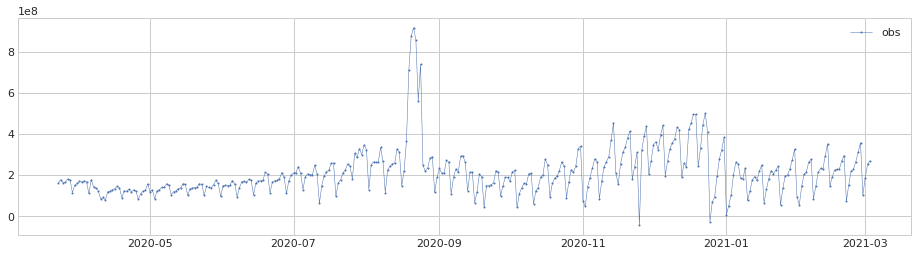

In [819]:
y_df = df_dow \
    .siu_arrange('date') \
    .siu_rename(obs = 'observed_centered') \
    .siu_select('date', 'obs') \
    .set_index('date')
s_c = validate_series(y_df)
level_shift_ad = LevelShiftAD(c=6.0, side='both', window=14)
anomalies = level_shift_ad.fit_detect(s_c)
plot(s_c, anomaly=anomalies, anomaly_color='red');

## Comparison

In [743]:
df_s['baseline']=df_dow \
    .siu_filter(_.date >= '2020-03-23', _.date <= '2020-03-29') \
    .observed.mean()
df_s['tcp_adj'] = 100*(df_s['obs_tr']-df_s['baseline'])/df_s['baseline']
#df_s.head()

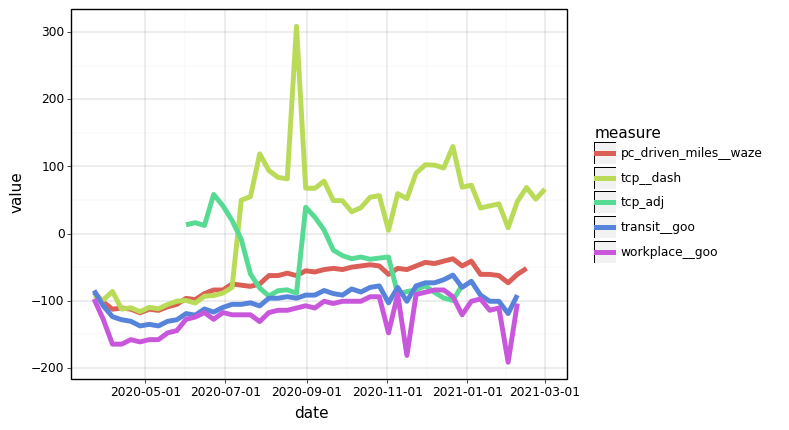

<ggplot: (8757124261753)>

In [744]:
df=df_dow \
    .merge(df_scale, on=['date', 'region_slug'], how='left') \
    .merge(df_s, on='date', how='inner') \
    .siu_select('region_slug', 'date', 
                'tcp_adj', 'tcp__dash',
                'pc_driven_miles__waze', 'transit__goo', 'workplace__goo') \
    .siu_gather('measure', 'value', _['tcp_adj', 'tcp__dash',
                'pc_driven_miles__waze', 'transit__goo', 'workplace__goo'])
(p9.ggplot(data=df,
           mapping=p9.aes(x='date', y='value', color = 'measure')) 
    + p9.geom_line(size = 2) 
)

# Process

In [541]:
import numpy as np
import pandas as pd
#import logger from loguru
from datetime import datetime, timedelta
from adtk.data import validate_series
from adtk.visualization import plot
from adtk.detector import LevelShiftAD, PersistAD, GeneralizedESDTestAD, SeasonalAD, AutoregressionAD
from tsmoothie.smoother import DecomposeSmoother


## Functions

In [542]:
### Shift functions
def _validate_series(df, column_name):
    # series to validate

    y_df = df.sort_values(['region_slug', 'date'])[['date', column_name]].set_index('date')
    s = validate_series(y_df)
    
    return s

def _level_shift_detection(s, c_param):
    # detector of level shift
    
    level_shift_ad = LevelShiftAD(c=c_param, side='both', window=14)
    anomalies = level_shift_ad.fit_detect(s)
    #plot(s, anomaly=anomalies, anomaly_color='red')
    
    return anomalies

def _shifted_ts(shift, column_name, df):
    # shift ts level
    
    # shift level happening
    shift_init = shift[shift[column_name] == 1].date.min()
    
    # a two weeks both sided window
    shift_wdw_init = shift_init - timedelta(days=14)
    shift_wdw_end  = shift_init + timedelta(days=14)

    # level centered
    center_point = ((df[(df['date'] >  shift_wdw_init) & 
                        (df['date'] <= shift_init)].observed.mean()) -
                    (df[(df['date'] >  shift_init) & 
                        (df['date'] <= shift_wdw_end)].observed.mean())
                   )

    # change print to logger
    print(center_point)

    df['obs_shifted'] = df[column_name]
    df['obs_shifted'][(df['date'] > shift_init)] = ((df[column_name][(df['date'] > shift_init)]) + center_point)

    return df, shift_init
    

In [638]:
### Outlier functions
def _outlier_persist_ad(s, c_param = 4, window_param = 14):
    persist_ad = PersistAD(c=c_param, side='both', window = window_param)
    #persist_ad.window = 14
    anomalies = persist_ad.fit_detect(s)

    return(anomalies)

def _outlier_gesdt_ad(s, alpha_param = 0.3, window_param = 14):
    esd_ad = GeneralizedESDTestAD(alpha=alpha_param)
    anomalies = persist_ad.fit_detect(s)

    return(anomalies)

def _outlier_seasonal_ad(s, c_param = 3.0, window_param = 14):
    seasonal_ad = SeasonalAD(c=c_param, side="both")
    anomalies = seasonal_ad.fit_detect(s)

    return(anomalies)

def _outlier_autregr_ad(s, c_param = 3.0, n_steps_param = 14, step_size_param=1):
    autoregression_ad = AutoregressionAD(n_steps=n_steps_param, step_size=step_size_param, c=c_param)
    anomalies = autoregression_ad.fit_detect(s)
    
    return(anomalies)

def _anomalies_detector(s):
    anomalies = _outlier_persist_ad(s) \
        .rename(columns={'obs_shifted':'anomaly_persist'}) \
        .reset_index() \
        .merge(_outlier_seasonal_ad(s) \
               .rename(columns={'obs_shifted':'anomaly_seasonal'}) \
               .reset_index()) \
        .merge(_outlier_autregr_ad(s) \
               .rename(columns={'obs_shifted':'anomaly_autor'}) \
               .reset_index()) \
        .fillna(0)
    #plot(s, anomalies, ts_linewidth=1)
    anomalies['anomaly_sum'] = \
        (anomalies['anomaly_persist']) + \
        (anomalies['anomaly_seasonal'] == True) +  \
        (anomalies['anomaly_autor'])
    anomalies.head(2)
    
    return(anomalies[anomalies.anomaly_sum > 0])


In [653]:
### Imputation functions
def _decompose_lowess(variable_smooth, missing_values):
    # operate smoothing
    # variable_smooth = (df_imputate.obs_shifted)
    smoother = DecomposeSmoother(smooth_type='lowess', periods=7,
                             smooth_fraction=0.2)
    smoother.smooth(variable_smooth)

    result = variable_smooth
    smooth_result = smoother.smooth_data[0]
    result[missing_values] = smooth_result[missing_values]
    
    return result


In [671]:
### Plot functions
def _plot_levelshift(df_shift, observed_variable):
    gg = (p9.ggplot(data=df_shift,
               mapping=p9.aes(x='date', y=observed_variable)) 
        + p9.geom_line(size = 1) 
        + p9.geom_line(p9.aes(y = 'obs_shifted'), size = 1, color = "red") 
        + p9.labs(title='Level Shift')
         )
    return gg
    
def _plot_anomalies(df_anomaly):
    gg = (p9.ggplot(data=df_anomaly,
               mapping=p9.aes(x='date', y='obs_shifted')) 
        + p9.geom_line(size = 1) 
        + p9.geom_point(p9.aes(size = 'anomaly_sum', color ='anomaly_sum') )
        + p9.labs(title='Anomalies identified')
         )
    return gg
    
def _plot_imputation(df_imputate):
    gg = (p9.ggplot(data=df_imputate.reset_index(),
           mapping=p9.aes(x='date', y='obs_shifted')) 
        + p9.geom_line(color = 'gray') 
        + p9.geom_line(p9.aes(y = 'RollingMean'), color = "red", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'Cubic'), color = "green", alpha = .4) 
        + p9.geom_line(p9.aes(y = 'RollingMedian'), color = "blue", alpha = .4)
        + p9.geom_line(p9.aes(y = 'Loess'), color = "black") 
        + p9.labs(title='Imputation of a')
         )    
    return gg

In [669]:
### Process functions

def _shift_level(df, observed_variable):
    # 1. Shift level
    
    df['obs_shifted'] = df[observed_variable]
    run_param = True
    dates_list = list()
    shift_cnt = 0

    while run_param:

        # detect shifts of level in the data
        #c_param = c_param
        s = _validate_series(df_dow, column_name='obs_shifted')
        shift = _level_shift_detection(s, c_param = 6.0).reset_index()

        # it there are shifts, rescaled the data
        # only run if there're more shifts
        run_param = sum(shift[column_name] == 1)>0 
        print(run_param)
        if run_param:
            shift_cnt=+1
            df_shift, date_shift = _shifted_ts(shift, 
                                               column_name='obs_shifted', 
                                               df=df_dow)
            dates_list.append(date_shift)

    print('Shifts found: ' + str(shift_cnt))  
    dates_list
    print(df_shift.shape)
    print(_plot_levelshift(df_shift, observed_variable))
    
    return df_shift

# 2. Find anomalies
def _find_anomalies(df_shift):

    s = _validate_series(df_shift, column_name= 'obs_shifted')
    df_anomaly = df_shift.merge(_anomalies_detector(s), how = 'left')
    anomalies_cnt = sum(df_anomaly.anomaly_sum >= anomaly_vote_minimun)
    print('Anomalies found: ' + str(anomalies_cnt))  
    print(df_anomaly.shape)
    print(_plot_anomalies(df_anomaly))
    
    return(df_anomaly)

# 3. Impute anomalies
def _impute_anomalies(df_anomaly, anomaly_vote_minimun):
    
    df_anomaly['obs_missing'] = df_anomaly['obs_shifted']
    df_anomaly['obs_missing'][df_anomaly.anomaly_sum >= anomaly_vote_minimun] = None
    df_anomaly['obs_missing'][df_anomaly['obs_missing'] < 0] = None
    df_impute = df_anomaly.set_index('date')

    df_impute =  df_impute \
        .assign(RollingMean=df_impute.obs_missing \
                    .fillna(df_impute.obs_missing \
                            .rolling(30, min_periods=1,) \
                            .mean()) ) \
        .assign(RollingMedian=df_impute.obs_missing \
                    .fillna(df_impute.obs_missing \
                            .rolling(30, min_periods=1,) \
                            .median()) ) \
        .assign(Cubic=df_impute.obs_missing \
                    .interpolate(method='polynomial', order = 5)) \
        .assign(Loess=_decompose_lowess(df_impute.obs_shifted, 
                                        df_impute.obs_missing.isna())) 

    print(df_impute.shape)
    print(_plot_imputation(df_impute))
    
    return df_impute

## Process

True
-337479847.71428573
False
Shifts found: 1
(351, 12)


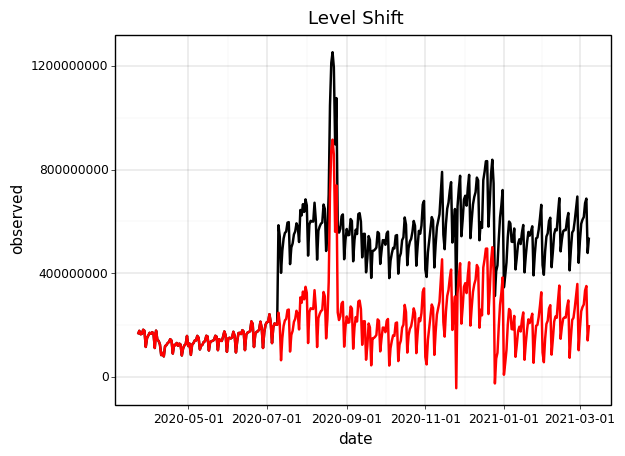

<ggplot: (8764285051841)>
Anomalies found: 18
(351, 16)


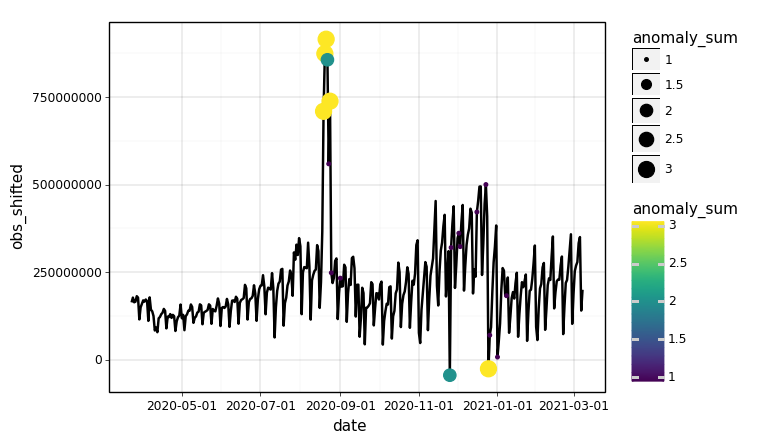

<ggplot: (8764285186877)>
(351, 20)


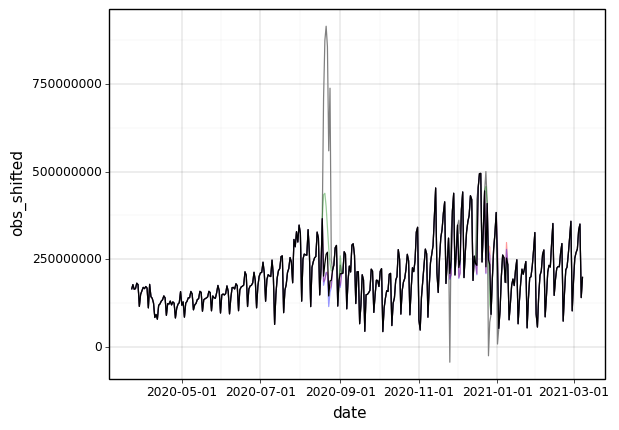

<ggplot: (8764285423861)>


In [672]:
# 1. Shift level
df_shift = _shift_level(df_dow, observed_variable = 'observed')

# 2. Find anomalies
df_anomaly = _find_anomalies(df_shift)

# 3. Impute anomalies
df_impute = _impute_anomalies(df_anomaly, anomaly_vote_minimun = 1)